In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# New Loss

In this notebook, I will code up a DFE with new loss function discussed on July 18th, 2022.

The loss function is as follows:

$$\sum\limits_{i,j \in V}|d_{diff}(x_i,x_j)-||\phi(x_i)-\phi(x_j)||_2|$$ $$+ \beta \sum\limits_{i \in V} \sum\limits_{k \in N_f(i)} ||(\phi(x_k)-\phi(x_i))-f(\phi(x_i))||_2$$ $$+ \gamma \cdot smoothness$$ $$+ \delta \cdot CLL (contrastive learning loss)$$

# Affinity Functions

In [2]:
def affinity_from_flow(flow, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flow : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flow.shape) == 2 # flow should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = F.normalize(directions_array,dim=-1)
  # and normalize flow # TODO: Perhaps reconsider
  # Calculate flow lengths, used to scale directions to flow
  # flow_lengths = torch.linalg.norm(flow,dim=-1)
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # scale directions to have same norm as flow
  # scaled_directions = normed_directions * flow_lengths[:,None].repeat(directions_array.shape[0],1,directions_array.shape[2])
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flow).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flow,dim=1)).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  # print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  return kernel

In [3]:
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flow,n_neighbors=None,sigma=0.5, flow_strength=1):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # dimension 1 represents directions to point i
  # dimension 2 represents direction from point j
  # dimension 3 represents direction in each dimension (R^n)
  # compute affinities from flow and directions
  affinities = affinity_from_flow(flow,P3,sigma=sigma,flow_strength=flow_strength)
  return affinities

# Flexible FlowArtist and Encoder (ReLU MLPs) Object Creator Function

In [4]:
from collections import OrderedDict

def FlowArtist(dim = 2, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    
    # create MLP
    FA = nn.Sequential(d) # d is an OrderedDictionary
        
    return FA

In [5]:
class FeedForwardReLU(nn.Module):
    def __init__(self, shape):
        super(FeedForwardReLU, self).__init__()
        d_len = len(shape) * 2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1, d_len - 3):
            if i % 2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i / 2)], shape[int(i / 2) + 1])
        # create MLP
        self.FA = nn.Sequential(d)

    def forward(self, X):
        return self.FA(X)

# Loss Functions

In [6]:
def diffusion_map_loss(P_graph, embedded_points):
  num_nodes = P_graph.shape[0]
  D_graph = torch.cdist(P_graph, P_graph)
  D_embedding = torch.cdist(embedded_points, embedded_points)
  loss = torch.norm(D_graph - D_embedding)**2 / (num_nodes**2)
  return loss

def near_neighbors_tensor(points, affinity_matrix, k):
    # returns n x k (neighbors) x dimensions Tensor
    A = affinity_matrix
    n = A.shape[0]
    d = points.size()[1]
    _, indices = torch.topk(A, k)
    
    ret = torch.empty(size=(n,k,d)).to(device)
    
    for i in range(indices.size()[0]):
        for j in range(indices.size()[1]):
            index = indices[i][j]
            ret[i][j] = points[index]
    
    return ret

def flow_neighbor_loss(points, near_neighbors, encoder, flow_artist):
    
    k = near_neighbors.shape[1]
    embedded_points = encoder(points)
    embedded_points = embedded_points[:,None,:].repeat(1,k,1)
    
    big_mat = encoder(near_neighbors) - embedded_points - flow_artist(embedded_points)
    norms = torch.linalg.norm(big_mat, dim = 2)
    
    return torch.sum(norms)

### Test Functions

In [7]:
points = [[0,0],
         [1,0],
         [0,1],
         [-1,0],
         [0,-1]]

flow = [[1,0],
         [1,0],
         [1,0],
         [1,0],
         [1,0]]

points = torch.tensor(points).float()
flow = torch.tensor(flow).float()

#plt.scatter(points[:,0], points[:,1])
#plt.quiver(points[:,0], points[:,1], flow[:,0], flow[:,1])

In [8]:
A = affinity_matrix_from_pointset_to_pointset(points, points, flow)
A
#plt.imshow(A)

tensor([[0.1353, 0.1353, 0.0183, 0.0025, 0.0183],
        [0.0025, 0.1353, 0.0019, 0.0003, 0.0019],
        [0.0183, 0.0329, 0.1353, 0.0019, 0.0025],
        [0.1353, 0.0183, 0.0329, 0.1353, 0.0329],
        [0.0183, 0.0329, 0.0025, 0.0019, 0.1353]])

In [9]:
near_neighbors_tensor(points, A, 2).size()[2]

2

# Embedder Class

In [43]:
class FlowEmbedder(torch.nn.Module):
    def __init__(
        self,
        X,
        flow,
        sigma_graph=0.5,
        flow_strength_graph=5,
        embedding_dimension=2,
        learning_rate=1e-3,
        FAShape=(2, 4, 8, 4, 2),
        EncShape=(3, 4, 8, 4, 2),
        decoder=None,
        labels=None,
        loss_weights=None,
        knn = 10,
        device=torch.device("cpu"),
    ):
        # initialize parameters
        super(FlowEmbedder, self).__init__()

        # generate default parameters
        embedder = (
            FeedForwardReLU(shape=EncShape)
        )
        loss_weights = (
            {
                "points": 1,
                "flow": 1,
                "smoothness": 0,
                "CLL": 0,
            }
            if loss_weights is None
            else loss_weights
        )
        self.X = X
        self.flow = flow
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]

        self.loss_weights = loss_weights
        self.labels = labels
        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device

        # Affinity Matrix in Ambient Space
        self.P_graph = affinity_matrix_from_pointset_to_pointset(
            X, X, flow, sigma=sigma_graph, flow_strength=flow_strength_graph
        )
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        
        # Ambient space points neighbors
        self.knn = knn
        self.near_neighbors = near_neighbors_tensor(self.X, self.P_graph, self.knn)
        
        # Flow field
        self.FlowArtist = FlowArtist(dim = 2, 
                                     shape = FAShape, 
                                     device = torch.device('cpu')
        ).to(self.device)

        # Autoencoder to embed the points into a low dimension
        
        self.embedder = embedder
        if decoder is not None:
            self.decoder = decoder.to(self.device)
        else:
            self.decoder = None

        # training ops
        self.optim = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # split input data into batches

    def loss(self, epoch):
        # embed points
        self.embedded_points = self.embedder(self.X)
        # compute diffusion loss on embedded points
        
        #"""
        # compute point embedding loss according to diffusion maps
        diffmap_loss = diffusion_map_loss(self.P_graph, self.embedded_points)
        self.losses["points"].append(diffmap_loss)
        #"""
        
        #"""
        # compute flow field loss
        flow_loss = flow_neighbor_loss(self.X, self.near_neighbors, self.embedder, self.FlowArtist)#*10e-6
        self.losses["flow"].append(flow_loss)
        #"""

        """
        if epoch < 2000:
            loss = diffmap_loss
        else:
             loss = diffmap_loss + flow_loss*10e-5
        """
        loss = diffmap_loss + flow_loss*10e-5
        
        return loss

    def visualize_points(self, labels=None):
        embedded_points = self.embedder(X)
        
        xmin = float(torch.min(embedded_points[:,0]))
        xmax = float(torch.max(embedded_points[:,0]))
        ymin = float(torch.min(embedded_points[:,1]))
        ymax = float(torch.max(embedded_points[:,1]))
        
        x_grid = torch.arange(xmin, xmax, (xmax-xmin)/20)
        y_grid = torch.arange(ymin, ymax, (ymax-ymin)/20)
        
        grid = []
        
        for i in range(20):
            for j in range(20):
                grid.append([x_grid[i], y_grid[j]])
        
        grid = torch.tensor(grid).float().to(device)
        flow = self.FlowArtist(grid)
        
        plt.scatter(embedded_points[:,0].cpu().detach(), embedded_points[:,1].cpu().detach(), c=labels)
        plt.quiver(grid[:,0].cpu().detach(),grid[:,1].cpu().detach(),flow[:,0].cpu().detach(),flow[:,1].cpu().detach())
        plt.show()

    def visualize_loss(self, loss_type="total"):
        # diffusion_loss,reconstruction_loss, smoothness_loss
        x = []
        k = ""
        losses = {}
        for key in self.losses.keys():
            losses[key] = []
            k = key
        losses["total"] = []
        for i in range(len(self.losses["points"])):
            x.append(i)
            for key in self.losses.keys():
                try:
                    losses[key].append(self.losses[key][i].detach().cpu().numpy())
                except:
                    losses[key].append(0)
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(x, losses[key])
            plt.legend(self.losses.keys(), loc="upper right")
            plt.title("loss")
        else:
            plt.plot(x, losses[loss_type])
            plt.title(loss_type)
        
    def fit(self, n_steps=1000):
        # train Flow Embedder on the provided graph
        self.train()
        # reset losses
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []
        # self.weight_of_flow = 0
        for step in trange(n_steps):
            # vary weight of each part of loss function
            """ 
            if step == 100:
                self.weight_of_flow = 1
            if step == 200:
                self.weight_of_flow = 0.5
            """
            self.optim.zero_grad()
            # compute loss
            loss = self.loss(step)
            if loss.isnan():
                print("Final loss was nan")
                raise NotImplementedError
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            # print progress report after every 500 epochs
            #"""
            if step % 100 == 0:
                print(f"EPOCH {step}.")
                self.visualize_points(labels)
            #"""
            # TODO: Criteria to automatically end training
        # print("Exiting training with loss ",loss)
        # return self.embedded_points, self.FlowArtist, self.losses

# Testing library functions

In [11]:
A = [[3,2,1],[5,4,6],[9,7,8]]
A = torch.tensor(A).float()

A

tensor([[3., 2., 1.],
        [5., 4., 6.],
        [9., 7., 8.]])

In [12]:
_, indices = torch.topk(A, 2)
indices

tensor([[0, 1],
        [2, 0],
        [0, 2]])

In [13]:
ret = np.empty(shape=(10,4))

In [14]:
p = [[1,0], [0,1]]
p = torch.tensor(p).float()

p.repeat(2,1,1)

tensor([[[1., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.]]])

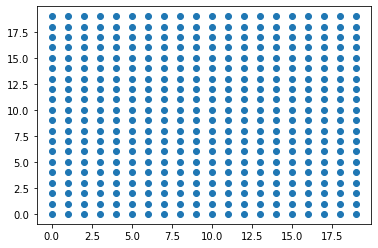

In [15]:
xmin = 0
xmax = 20
ymin = 0
ymax = 20

x_grid = torch.arange(xmin, xmax, (xmax-xmin)/20)
y_grid = torch.arange(ymin, ymax, (ymax-ymin)/20)
        
grid = []
        
for i in range(20):
    for j in range(20):
        grid.append([x_grid[i], y_grid[j]])
    
grid = np.asarray(grid)
    
plt.scatter(grid[:,0], grid[:,1])

# Testing the Embedder